# Geometrical Methods in Machine Learning
## Seminar 3: Intrinsic Dimension Estimation

In [1]:
from __future__ import print_function

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from math import pi
from sklearn.datasets import load_digits, fetch_olivetti_faces
from sklearn.neighbors import NearestNeighbors

## 1. Maximum Likelihood

MLE is the average of estimators $\hat{m}_k$ for several values of $k$ where $\hat{m}_k$ in turn is the average of local maximum likelihood estimators $\hat{m}_k(x_i)$, which estimate the dimension of the data around a sample point $x_i$ based on the distances between $x_i$ and its $k$ nearest neighbor.

In [2]:
"""
Implementation of 'Maximum Likelihood Estimation of Intrinsic Dimension' by Elizaveta Levina and Peter J. Bickel
 
how to use
----------
 
The goal is to estimate intrinsic dimensionality of data, the estimation of dimensionality is scale dependent
(depending on how much you zoom into the data distribution you can find different dimesionality), so they
propose to average it over different scales, the interval of the scales [k1, k2] are the only parameters of the algorithm.
 
This code also provides a way to repeat the estimation with bootstrapping to estimate uncertainty.
 
Here is one example with swiss roll :
 
from sklearn.datasets import make_swiss_roll
X, _ = make_swiss_roll(1000)
 
k1 = 10 # start of interval(included)
k2 = 20 # end of interval(included)
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             X, 
                             mode='bootstrap', 
                             nb_iter=500, # nb_iter for bootstrapping
                             verbose=1, 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)
# the shape of intdim_k_repeated is (nb_iter, size_of_interval) where 
# nb_iter is number of bootstrap iterations (here 500) and size_of_interval
# is (k2 - k1 + 1).
 
# Plotting the histogram of intrinsic dimensionality estimations repeated over
# nb_iter experiments
plt.hist(intdim_k_repeated.mean(axis=1))
 
"""
# from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
 
def intrinsic_dim_sample_wise(X, k=5, neighb=None):
    if neighb is None:
        neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X)
    print("collected dist, ind")
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample
 
def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    
    for k in range(k1, k2 + 1, 5):
        print("calculating neighbours for: " + str(k))
        neighb = NearestNeighbors(n_neighbors=k+1, n_jobs=32).fit(X)
        print("done")
        m = intrinsic_dim_sample_wise(X, k, neighb).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
 
    iters = range(nb_iter) 
    for i in iters:
        if mode == 'bootstrap':
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

In [3]:
def intrinsic_dim_scale_interval(X, k1=10, k2=20, step=2): 
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    
    for k in range(k1, k2 + 1, step):
        print("calculating neighbours for: " + str(k))
        neighb = NearestNeighbors(n_neighbors=k+1, n_jobs=4).fit(X)
        print("done")
        m = intrinsic_dim_sample_wise(X, k, neighb).mean()
        intdim_k.append(m)
    return intdim_k

In [4]:
paths = [
    "../data/g/data_G.npy", 
    "../data/g/data_G_dropped_samples.npy", 
    "../data/g/data_G_pca_99.npy", 
    "../data/g/data_G_dropped_samples_pca_99.npy",
    "../data/f/data_F.npy", 
    #"../data/f/data_F_dropped_samples.npy", 
    "../data/f/data_F_pca_99.npy", 
    #"../data/f/data_F_dropped_samples_pca_99.npy", 
    "../data/o/data_O.npy", 
    #"../data/o/data_O_dropped_samples.npy", 
    "../data/o/data_O_pca_99.npy", 
    #"../data/o/data_O_dropped_samples_pca_99.npy",
]

In [6]:
def check_data(data):
    print(data.shape)
    return all(np.abs(data.sum(1) - 1) < 1e-7)

In [7]:
def sample_data(data, fraction):
    mask = np.random.binomial(1, fraction, data.shape[0]).astype(bool)
    return data[mask]

In [8]:
indims = {}
neigh = {}

In [9]:
paths[3:]

['../data/g/data_G_dropped_samples_pca_99.npy',
 '../data/f/data_F.npy',
 '../data/f/data_F_pca_99.npy',
 '../data/o/data_O.npy',
 '../data/o/data_O_pca_99.npy']

In [11]:
import tqdm

In [12]:
k1 = 10 # start of interval(included)
k2 = 50 # end of interval(included)
nb_iter = 3




for path in tqdm.tqdm(paths[:1]):
    print(path)
    d = np.unique(np.load(path), axis = 0)
    d = sample_data(d, 0.3)
    
    intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                                 d, 
                                 mode='bootstrap', 
                                 #mode = 'shuffle',
                                 nb_iter=nb_iter, # nb_iter for bootstrapping 
                                 k1=k1, k2=min(d.shape[1], k2), step=5)
    intdim_k_repeated = np.array(intdim_k_repeated)
    
    neighbors = np.arange(k1, min(d.shape[1], k2), 5)
    
    indims[path] = intdim_k_repeated
    neigh[path] = neighbors

  0%|          | 0/1 [00:00<?, ?it/s]

../data/g/data_G.npy
calculating neighbours for: 10
done
collected dist, ind
calculating neighbours for: 15
done
collected dist, ind
calculating neighbours for: 20
done
collected dist, ind
calculating neighbours for: 25
done
collected dist, ind
calculating neighbours for: 30
done
collected dist, ind
calculating neighbours for: 35
done
collected dist, ind
calculating neighbours for: 40
done
collected dist, ind
calculating neighbours for: 45
done
collected dist, ind
calculating neighbours for: 50
done
collected dist, ind
calculating neighbours for: 10
done
collected dist, ind
calculating neighbours for: 15
done
collected dist, ind
calculating neighbours for: 20
done
collected dist, ind
calculating neighbours for: 25
done
collected dist, ind
calculating neighbours for: 30
done
collected dist, ind
calculating neighbours for: 35
done
collected dist, ind
calculating neighbours for: 40
done
collected dist, ind
calculating neighbours for: 45
done
collected dist, ind
calculating neighbours for:

100%|██████████| 1/1 [01:01<00:00, 61.59s/it]

collected dist, ind


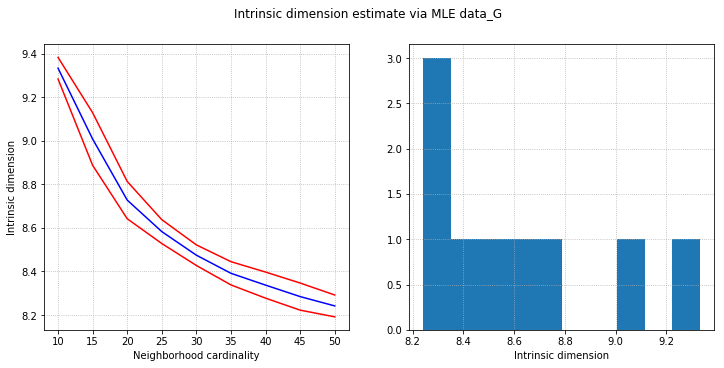

In [13]:
for k in indims.keys():
    intdim_k_repeated = indims[k]
    neighbors = neigh[k]

    fig = plt.figure(figsize=(12,5.25))

    plt.suptitle("Intrinsic dimension estimate via MLE " + k.split("/")[-1].split(".")[0])

    plt.subplot(121)
    plt.xlabel("Neighborhood cardinality")
    plt.ylabel("Intrinsic dimension")
    plt.grid(linestyle='dotted')

    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0), 'b')
    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')


#     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0), 'b')
#     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
#     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')


    plt.subplot(122)
    plt.xlabel("Intrinsic dimension")
    plt.grid(linestyle="dotted")

    plt.hist(intdim_k_repeated.mean(axis=0))
    plt.show()

In [171]:
intdim_k_repeated

array([[9.83746339, 9.5673068 , 9.39242163, 9.23688487, 9.13594657,
        9.03326194, 8.9573959 , 8.88692382, 8.82315886],
       [9.80082389, 9.55376533, 9.33776024, 9.18276842, 9.04249265,
        8.94252542, 8.86741781, 8.77354125, 8.70499563],
       [9.69252105, 9.48344393, 9.3188663 , 9.19514287, 9.0634152 ,
        8.94657427, 8.8535935 , 8.76446025, 8.69161353]])

In [172]:
neighbors

array([10, 15, 20, 25, 30, 35, 40, 45])

#### Exercise

1. Plot mean value and mean value +- std as a function of a sample size.
2. Plot mean value and mean value +- std as a function of a log_10(noise_std).

In [51]:
d = np.load(paths[0])

In [48]:
d.sum(1)

array([ 0.33564012, -0.54819532, -0.45071012, ..., -0.01190458,
       -0.13285617,  0.3704996 ])

In [53]:
check_data(d)

(14098, 266)


True

In [52]:
dists = np.zeros((data.shape[0], 10))

AttributeError: 'bool' object has no attribute 'shape'

In [54]:
from sklearn.metrics import euclidean_distances
import tqdm

In [55]:
%time m = euclidean_distances(data[:1000],data[:1000])

TypeError: 'bool' object is not subscriptable

In [62]:
np.unique(data, axis = 0).shape

(14074, 266)

In [61]:
data.shape

(14098, 266)

In [17]:
intdim_k = intrinsic_dim_scale_interval(np.unique(data, axis = 0))

calculating neighbours for: 10
done
collected dist, ind
calculating neighbours for: 12
done
collected dist, ind
calculating neighbours for: 14
done
collected dist, ind
calculating neighbours for: 16
done
collected dist, ind
calculating neighbours for: 18
done
collected dist, ind
calculating neighbours for: 20
done
collected dist, ind


In [26]:
indims

[array([[6.99463021, 6.85711207, 6.73150929, 6.64602994, 6.56559301,
         6.49660208, 6.43375799, 6.37325663, 6.32315246],
        [7.00154742, 6.87238312, 6.72599473, 6.63436727, 6.5517285 ,
         6.46134028, 6.39770073, 6.33289768, 6.27928487],
        [7.05560026, 6.91185246, 6.79321414, 6.70993524, 6.61761515,
         6.53920812, 6.47646792, 6.40691153, 6.35160835],
        [7.0295155 , 6.868478  , 6.75890747, 6.66712098, 6.57416925,
         6.48877559, 6.41998265, 6.35964901, 6.30582734],
        [7.05235299, 6.8968742 , 6.78039017, 6.67176409, 6.58347101,
         6.50968664, 6.43796701, 6.37474535, 6.32075661]]),
 array([[8.28779942, 8.05845387, 7.91133782, 7.79433763, 7.69068373,
         7.58983835, 7.5030078 , 7.41648605, 7.35246922],
        [8.23667932, 8.03444022, 7.86190028, 7.74758645, 7.64602844,
         7.55105437, 7.4578077 , 7.37635348, 7.30032478],
        [8.26551203, 8.0245624 , 7.85080706, 7.72424913, 7.61806479,
         7.52338938, 7.4417961 , 7.36754

In [ ]:
np.save("../../data/intdim_k_repeated_765", intdim_k_repeated)

In [40]:
np.mean(intdim_k_repeated, axis=0).shape

(24,)

In [45]:
intdim_k_repeated.shape[1]

24

In [11]:
np.mean(intdim_k_repeated, axis=0)

array([ 17.45034821,  17.15842092,  16.80625435,  16.5848997 ,
        16.35418898,  16.17836246,  16.02201548,  15.89827951,
        15.80019078,  15.69625894,  15.60604879,  15.52591361,
        15.44842344,  15.37156858,  15.28866677,  15.20399542,
        15.11769325,  15.04458659,  14.96122411,  14.8875284 ,
        14.80830255,  14.73035594,  14.66137828,  14.59783269])

In [56]:
data = np.load(paths[0])

In [ ]:
# your code here

### 1.2. Airfoils

#### Exercise

Estimate intrinsic dimension of airfoils sample and compare results with PCA ones.

In [ ]:
data_airfoils = np.loadtxt('../seminar1/data/airfoils.csv', delimiter=',')
data_airfoils.shape

In [ ]:
k1 = 3 # start of interval(included)
k2 = 50 # end of interval(included)
nb_iter = 20

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data_airfoils, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

ValueError: x and y must have same first dimension, but have shapes (41,) and (9,)

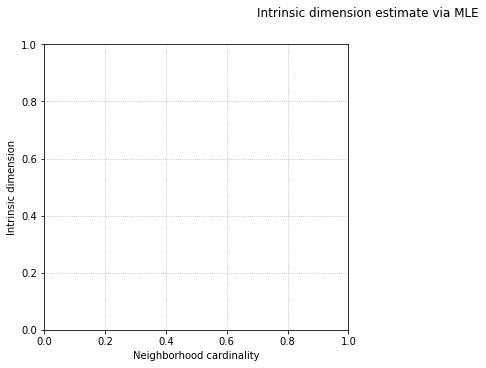

In [29]:
fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
plt.show()

### 1.3 MNIST

#### Exercise

Estimate intrinsic dimension of digits sample and compare results with PCA ones

In [ ]:
data_mnist = load_digits().data
data_mnist.shape

In [ ]:
k1 = 3 # start of interval(included)
k2 = 50 # end of interval(included)
nb_iter = 5

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data_mnist, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

In [ ]:
fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
plt.show()

### 1.4 Olivetti faces

#### Exercise

Estimate intrinsic dimension of faces sample and compare results with PCA ones.

In [ ]:
data_faces = fetch_olivetti_faces(shuffle=True).data
data_faces.shape

In [ ]:
k1 = 3 # start of interval(included)
k2 = 50 # end of interval(included)
nb_iter = 5

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data_faces, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

ValueError: x and y must have same first dimension, but have shapes (41,) and (9,)

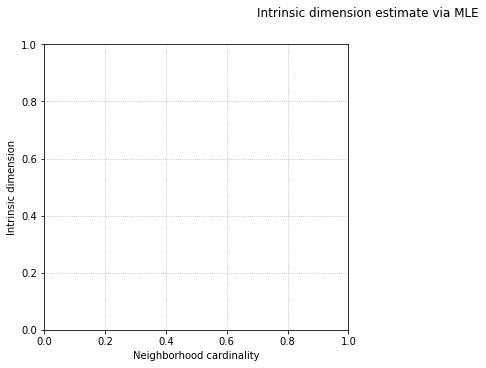

In [28]:
fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
plt.show()

## 2. Local PCA

Let $\{x_1, x_2, \dots, x_n \} \subset \mathbb{R}^D$ be a data sample and $U(x_i)$ - a neighborhood of each point, excluding $x_i$ itself, with cardinality $k$. By applying PCA locally, i.e. computing eigenvalues $\lambda_{i,1} \geq \lambda_{i,2} \geq \dots \lambda_{i,D}$ of each neighborhood covariance matrix: $\mathbf{S}_i = \frac{1}{k-1}(\mathbf{U}(x_i) - x_i) (\mathbf{U}(x_i) - x_i)^T$ and then averaging over eigenvalues $\lambda_j = n^{-1} \sum_{i=1}^n \lambda_{i,j}$, where $j = 1, 2, \dots, D$ one can estimate intrinsic dimension $d$ by thresholding variance explained with averaged eigenvalues.

#### Exercise

1. Implement Local PCA method for intrinsic dimensionality estimation (lecture slides, pp. 28-32).  
2. Apply the method to artificial and real data, compare results with global PCA and MLE methods for different number of nearest neighbors $k$, conclude.

For neighborhood selection you may use `kneigbbors` method from scikit-learn's `NearestNeighbors`.

In [ ]:
# k of nearest neighbors to select
k = 9

# your code here

#### Exercise

Compute explained and cumulative explained variance. Use results to estimate intrinsic dimension of data samples.

$$EV_i := \frac{\lambda_i}{\lambda_1 + \dots + \lambda_D}$$
$$CEV_i := \frac{\sum_{i=1}^{d} \lambda_i}{\sum_{j=1}^{D} \lambda_j}$$

In [ ]:
EV = 
CEV = 

In [ ]:
# plot EV/CEVs
fig = plt.figure(figsize=(12,5.25))

plt.subplot(121)
plt.title("Explained variance")
plt.xlabel("# PCs")
plt.grid(linestyle="dotted")
plt.plot(EV, "o-")

plt.subplot(122)
plt.title("Cumulative explained variance")
plt.axhline(linewidth=1, y=0.99, color='r')
plt.axhline(linewidth=1, y=0.95, color='r')
plt.axhline(linewidth=1, y=0.9, color='r')
plt.axhline(linewidth=1, y=0.8, color='r')
plt.xlabel("# PCs")
plt.grid(linestyle="dotted")
plt.plot(CEV, "o-")